In [1]:
import numpy as np
import matplotlib.pyplot as plt

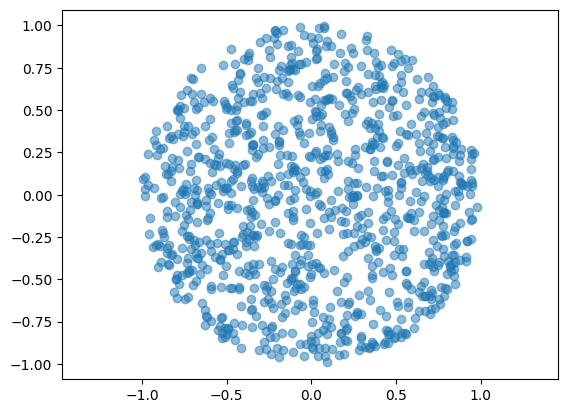

In [2]:
def sample_circle(n_points: int, radius: float = 1.0) -> np.ndarray:
    def generate_circle(n_points: int, radius: float = 1.0) -> np.ndarray:
        """Generate points uniformly distributed within a circle.
        
        Uses rejection sampling for efficiency.
        """
        # Generate points in a square and reject those outside circle
        points = (np.random.random((n_points, 2)) - 0.5) * 2 * radius
        mask = np.sum(points**2, axis=1) <= radius**2
        return points[mask]

# Draw points until we have 1000
    points = []
    while len(points) < n_points:
        new_points = generate_circle(n_points - len(points))
        points.extend(new_points)
    return np.array(points[:n_points])

points = sample_circle(1000)
plt.scatter(points[:, 0], points[:, 1], alpha=0.5)
plt.axis('equal')
plt.show()


In [3]:
points.shape

(1000, 2)

In [4]:
def gaussian_activation(center: np.ndarray, points: np.ndarray, sigma: float = 0.1) -> np.ndarray:
    """Calculate Gaussian activation values for all points relative to a center.
    
    Args:
        center: Center point coordinates of shape (2,)
        points: Array of points to evaluate, shape (N, 2)
        sigma: Width parameter of the Gaussian
        
    Returns:
        Array of activation values for each point, shape (N,)
    """
    distances = np.sum((points - center)**2, axis=1)
    return np.exp(-distances / (2 * sigma**2))

# Example usage


def plot_activations(activations: np.ndarray, points: np.ndarray, center: np.ndarray):
    plt.figure(figsize=(10, 4))

    # Plot points colored by activation
    plt.subplot(121)
    plt.scatter(points[:, 0], points[:, 1], c=activations, cmap='viridis')
    plt.colorbar(label='Activation')
    plt.plot(center[0], center[1], 'r*', markersize=15, label='Center')
    plt.axis('equal')
    plt.legend()

    # Plot activation surface
    xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
    grid_points = np.column_stack((xx.ravel(), yy.ravel()))
    grid_activations = gaussian_activation(center, grid_points)
    plt.subplot(122)
    plt.contourf(xx, yy, grid_activations.reshape(100, 100), levels=20, cmap='viridis')
    plt.colorbar(label='Activation')
    plt.plot(center[0], center[1], 'r*', markersize=15, label='Center')
    plt.axis('equal')
    plt.legend()

    plt.tight_layout()
    plt.show()


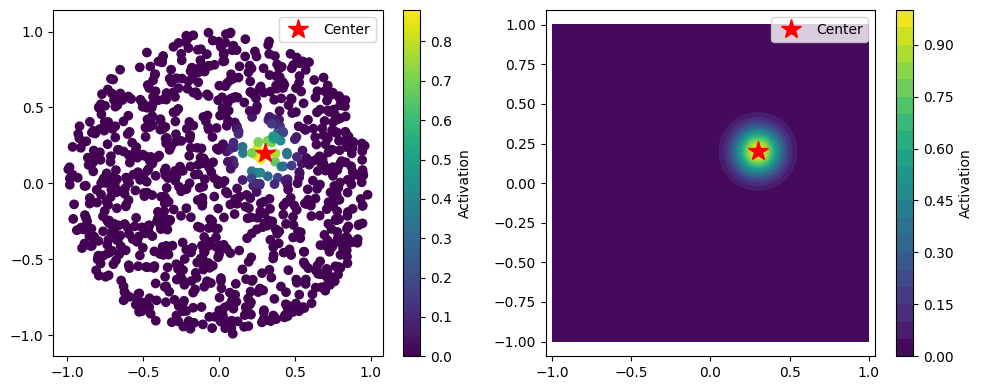

In [5]:
center = np.array([0.3, 0.2])
activations = gaussian_activation(center, points)

plot_activations(activations=activations, points=points, center=center)

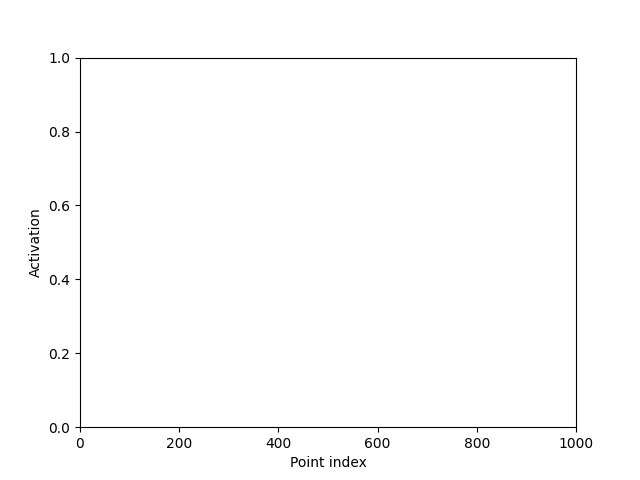

In [11]:
%matplotlib ipympl

from matplotlib.animation import FuncAnimation

# Create a line of centers
t = np.linspace(0, 1, 50)
centers = np.column_stack((0.3 + 0.4*t, 0.2 + 0.3*t))

fig, ax = plt.subplots()
line, = ax.plot([], [])
ax.set_xlim(0, len(points))
ax.set_ylim(0, 1)
ax.set_xlabel('Point index')
ax.set_ylabel('Activation')

def update(frame):
    center = centers[frame]
    activations = gaussian_activation(center, points)
    line.set_data(np.arange(len(activations)), activations)
    return line,

anim = FuncAnimation(fig, update, frames=len(centers), interval=50, blit=True)
plt.show()

In [15]:
n_features_vectors = 10000
features_vectors = []
centers = sample_circle(n_features_vectors)
for center in centers:
    features_vectors.append(gaussian_activation(center, points))

features_vectors = np.array(features_vectors)
features_vectors.shape


(10000, 1000)

In [16]:
from sklearn.manifold import TSNE
tsne_embedding = TSNE(n_components=2).fit_transform(features_vectors)
tsne_embedding.shape


(10000, 2)

In [17]:
centers.shape

(10000, 2)

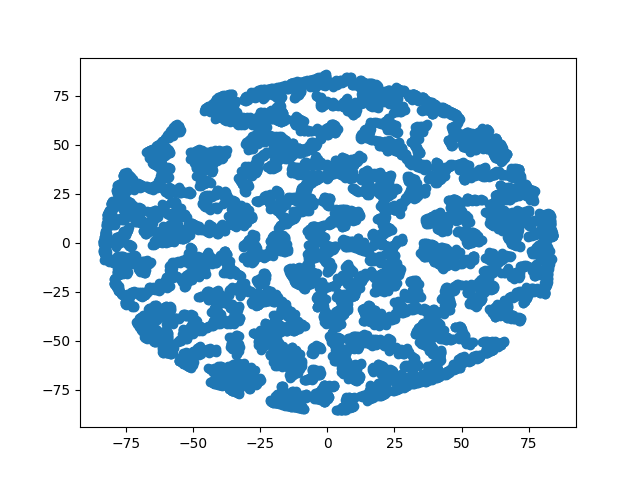

In [18]:
plt.figure()

plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1])
plt.show()


In [19]:
centers.shape

(10000, 2)

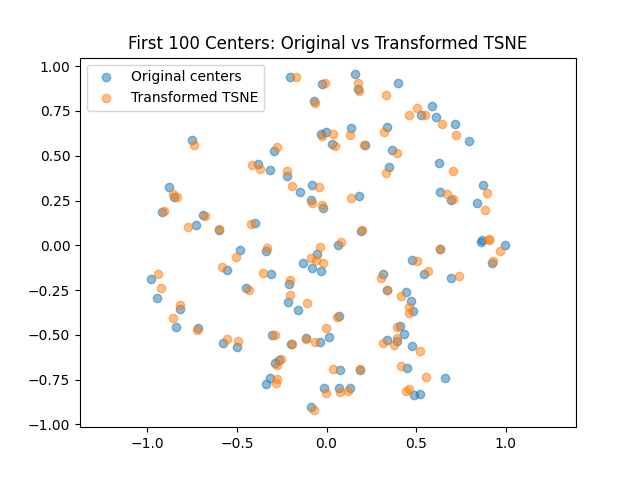

In [23]:
from sklearn.linear_model import LinearRegression

# Standardize both point sets to have zero mean and unit variance
centers_mean = centers.mean(axis=0)
centers_std = centers.std(axis=0)
centers_normalized = (centers - centers_mean) / centers_std

tsne_mean = tsne_embedding.mean(axis=0) 
tsne_std = tsne_embedding.std(axis=0)
tsne_normalized = (tsne_embedding - tsne_mean) / tsne_std

# Find optimal rotation and scale using linear regression
# Fit Y = AX where Y is centers and X is TSNE embeddings
reg = LinearRegression(fit_intercept=False)
reg.fit(tsne_normalized, centers_normalized)

# Transform TSNE points using learned affine transformation
tsne_transformed = (tsne_normalized @ reg.coef_.T) * centers_std + centers_mean

# Plot first 100 centers and their transformed TSNE embeddings
n_plot_points = 100
plt.figure()
plt.scatter(centers[:n_plot_points, 0], centers[:n_plot_points, 1], label='Original centers', alpha=0.5)
plt.scatter(tsne_transformed[:n_plot_points, 0], tsne_transformed[:n_plot_points, 1], label='Transformed TSNE', alpha=0.5)
plt.legend()
plt.title('First 100 Centers: Original vs Transformed TSNE')
plt.axis('equal')
plt.show()



In [ ]:
import bpy
from pathlib import Path

# Import the blend file
blend_path = Path("cube.blend")
bpy.ops.wm.open_mainfile(filepath=str(blend_path))

# Get the cube object
cube = bpy.data.objects["cube"]

# Ensure we're in object mode
bpy.context.view_layer.objects.active = cube
bpy.ops.object.mode_set(mode='OBJECT')

# Get mesh data
mesh = cube.data

# Iterate over faces and print centers
for face in mesh.polygons:
    # Calculate face center by averaging vertices
    center = face.center
    print(f"Face {face.index} center: ({center.x:.3f}, {center.y:.3f}, {center.z:.3f})")
